# Denoising Challenge

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Conv2D, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

K.set_image_data_format("channels_first")

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2207847687253056707
]


### Importing & prepare data

In [2]:
import numpy as np

with np.load('./data/denoising-challenge-01-data.npz') as fh:
        train_y = fh['training_images_clean']
        validation_x = fh['validation_images_noisy']
        validation_y = fh['validation_images_clean']
        test_x = fh['test_images_noisy']

### Data shapes

In [3]:
print('training: ' + str(train_y.shape))
print('validation: ' + str(validation_x.shape))
print('test: ' + str(test_x.shape))

training: (20000, 1, 28, 28)
validation: (2000, 1, 28, 28)
test: (2000, 1, 28, 28)


### Visualize some data

(1, 28, 28)


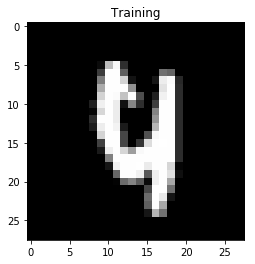

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title('Training')
print(train_y[0].shape)
plt.imshow(train_y[0].reshape(28,28), cmap='gray')

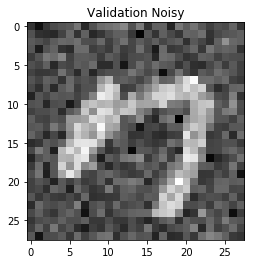

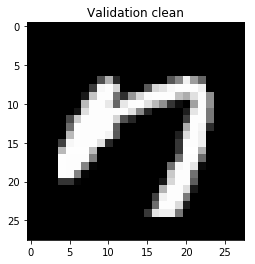

In [5]:
plt.figure()
plt.title('Validation Noisy')
plt.imshow(validation_x[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

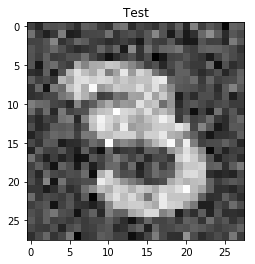

In [6]:
plt.figure()
plt.title('Test')
plt.imshow(test_x[0].reshape(28,28), cmap='gray')

### Calculate standart deviation of gaussian noise

In [7]:
noise = validation_x - validation_y
noise_sigma = np.std(noise)

noise_sigma

0.20003203

### Create a noise generator

In [8]:
def getNoisy(clean, sigma=noise_sigma):
    return clean + sigma * np.random.normal(0, 1, clean.shape)

### Check if we get everything right by adding noise to validation image and displaying it

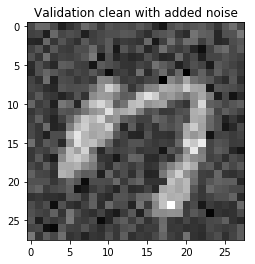

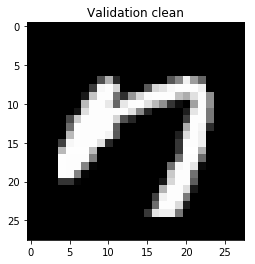

In [9]:
plt.figure()
plt.title('Validation clean with added noise')
plt.imshow(getNoisy(validation_y[0]).reshape(28, 28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

### Data Augmentation (Bootstrapping)

We don't really want to predict anything so we can go wild and crazy with the transformations (horizontal & vertical flips, random rotations, etc.). As we don't have much computing power however, we will only use flips, as they are pretty fast to compute.

In [10]:
def horizontalFlip(image):
    return np.flip(image, 3)

def verticalFlip(image):
    return np.flip(image, 2)

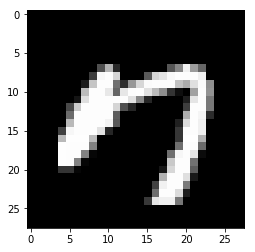

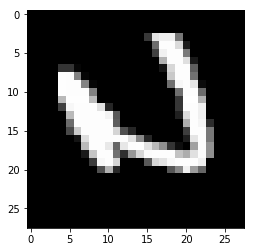

In [11]:
plt.figure("some image")
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

plt.figure("some vertically flipped image")
plt.imshow(verticalFlip(validation_y)[0].reshape(28,28), cmap='gray')

### Prepare data for training

In [12]:
def get_train_set(train_y):
    # augment data; better for general purpose denoisers, though for MNIST digits it doesn't make too much sense
    
    # train_enhanced = np.vstack([train_y, verticalFlip(train_y)])
    # train_enhanced = np.vstack([train_enhanced, horizontalFlip(train_y)])
    train_enhanced = train_y
    
    # repeat data, as we are going to add different noise to each image, more is more
    train_enhanced = np.repeat(train_enhanced, 5, axis=0)
    # add noise
    train_x = getNoisy(train_enhanced)
    
    return train_x, train_enhanced

## Model

We based our model entirely on residual denoising convolutional NN. Further information can be found in this paper (https://arxiv.org/pdf/1608.03981.pdf). 

#### All hyperparams

In [13]:
input_shape = train_y.shape[1:4]
# 64 masks is a much better way to go, though computing such a model on CPU takes way too long
hidden_layers = [16] * 15
kernel_size = (3,3)
strides = (1,1)
padding= 'same'

epochs = 50
batch_size = 128

#### Define Loss, Frobenius norm

In [14]:
def frobenius(yTrue, yPred):
    return K.sqrt(K.sum((yTrue - yPred)**2, axis=(1,2,3)))

#### VGG Network with residual learning

In [15]:
noisy_input = Input(shape=input_shape, name='noisy_input')
x = noisy_input
last_shortcut = x
for i, layer in enumerate(hidden_layers):
    x = Conv2D(layer, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.001)(x)
    x = Dropout(0.5)(x)
    
    if i % 4 == 0 and i != 0:
        shortcut_name = 'shortcut-{}'.format(i // 4)
        x = keras.layers.Add(name=shortcut_name)([x, last_shortcut])
        last_shortcut = x
    
# x = Conv2D(1, kernel_size, strides=strides, padding=padding, activation='sigmoid', name='image_noise')(x)
x = Conv2D(1, kernel_size, strides=strides, padding=padding, name='image_noise')(x)
x = keras.layers.Add(name='denoised_output')([noisy_input, x])
x = keras.layers.Activation('sigmoid')(x)
# make sure our images are valid by clipping the output to within the allowed values
model = Model(noisy_input, x, name='denoiser')
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy', frobenius])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noisy_input (InputLayer)        (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 28, 28)   160         noisy_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 28, 28)   112         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 28, 28)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

### Train

In [16]:
# get train data
X, y = get_train_set(train_y)

In [17]:
checkpointer = ModelCheckpoint(filepath='./model/weights.hdf5', verbose=1, save_best_only=True, 
                                               monitor='val_frobenius')
tensorboard = TensorBoard(log_dir='./stats/denoising')
stop = EarlyStopping(monitor="val_frobenius", min_delta=0.001, patience=5, mode="min")
history = model.fit(X, y,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                shuffle=True,
                validation_data=(validation_x, validation_y),
                callbacks=[checkpointer, tensorboard, stop])

Train on 100000 samples, validate on 2000 samples
Epoch 1/50
100000/100000 [==============================] - 1734s 17ms/step - loss: 0.0936 - acc: 0.8125 - frobenius: 2.3795 - val_loss: 0.0714 - val_acc: 0.8154 - val_frobenius: 1.5196

Epoch 00001: val_frobenius improved from inf to 1.51963, saving model to ./model/weights.hdf5
Epoch 2/50
100000/100000 [==============================] - 1649s 16ms/step - loss: 0.0750 - acc: 0.8140 - frobenius: 1.7479 - val_loss: 0.0705 - val_acc: 0.8154 - val_frobenius: 1.4819

Epoch 00002: val_frobenius improved from 1.51963 to 1.48195, saving model to ./model/weights.hdf5
Epoch 3/50
100000/100000 [==============================] - 1648s 16ms/step - loss: 0.0741 - acc: 0.8141 - frobenius: 1.7051 - val_loss: 0.0702 - val_acc: 0.8154 - val_frobenius: 1.4788

Epoch 00003: val_frobenius improved from 1.48195 to 1.47877, saving model to ./model/weights.hdf5
Epoch 4/50
100000/100000 [==============================] - 1645s 16ms/step - loss: 0.0737 - acc: 0

### Prediction

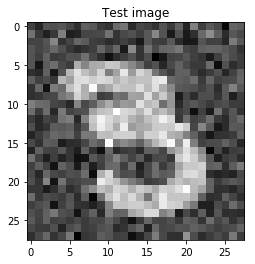

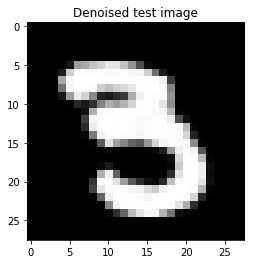

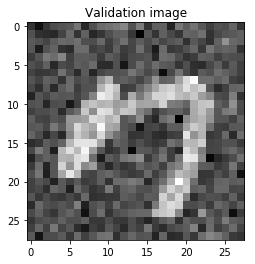

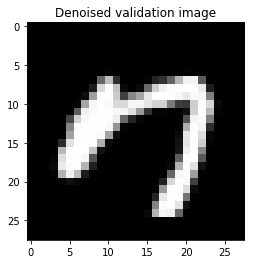

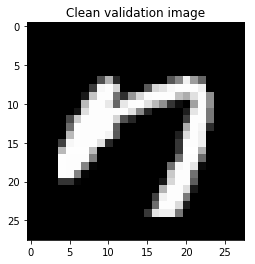

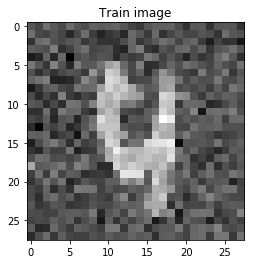

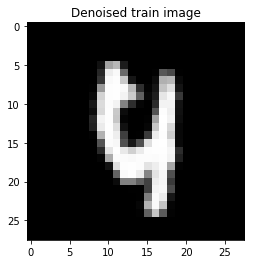

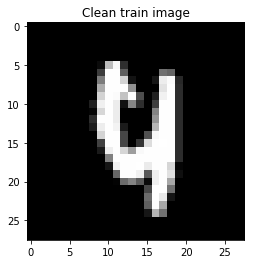

In [24]:
prediction = model.predict(test_x)
prediction_validation = model.predict(np.array([validation_x[0]]))
prediction_train = model.predict(np.array([X[0]]))

plt.figure()
plt.title("Test image")
plt.imshow(test_x[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title("Denoised test image")
plt.imshow(prediction[0].reshape(28,28), cmap='gray')


plt.figure()
plt.title("Validation image")
plt.imshow(validation_x[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title("Denoised validation image")
plt.imshow(prediction_validation[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title("Clean validation image")
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')



plt.figure()
plt.title("Train image")
plt.imshow(X[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title("Denoised train image")
plt.imshow(prediction_train[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title("Clean train image")
plt.imshow(y[0].reshape(28,28), cmap='gray')



In [26]:
np.save('prediction_vgg.npy', prediction)